In [9]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Project/Practice/Result_GAN/'

Mounted at /content/gdrive


In [10]:
# Load the dataset
def load_data():
  (x_train, y_train), (_, _) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [11]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 784)              

In [12]:
def build_discriminator():
    model = Sequential()
    
    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
      
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model
  
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)              

In [13]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input)
    GAN_output= discriminator(x)
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return GAN
  
GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path+'Generated_images %d.png' %epoch)

In [0]:
def train_GAN(epochs=1, batch_size=128):
    
  #Loading the data
  X_train, y_train = load_data()

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  for i in range(1, epochs+1):
    print("Epoch %d" %i)
    
    for _ in tqdm(range(batch_size)):
      # Generate fake images from random noiset
      noise= np.random.normal(0,1, (batch_size, 100))
      fake_images = generator.predict(noise)

      # Select a random batch of real images from MNIST
      real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

      # Labels for fake and real images           
      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size) 

      # Concatenate fake and real images 
      X = np.concatenate([fake_images, real_images])
      y = np.concatenate([label_fake, label_real])

      # Train the discriminator
      discriminator.trainable=True
      discriminator.train_on_batch(X, y)

      # Train the generator/chained GAN model (with frozen weights in discriminator) 
      discriminator.trainable=False
      GAN.train_on_batch(noise, label_real)

    # Draw generated images every 15 epoches     
    if i == 1 or i % 10 == 0:
      draw_images(generator, i)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  3%|▎         | 4/128 [00:00<00:03, 39.22it/s]

Epoch 2


  3%|▎         | 4/128 [00:00<00:03, 37.40it/s]

Epoch 3


  4%|▍         | 5/128 [00:00<00:03, 40.27it/s]

Epoch 4


  3%|▎         | 4/128 [00:00<00:03, 39.46it/s]

Epoch 5


  3%|▎         | 4/128 [00:00<00:03, 39.52it/s]

Epoch 6


  3%|▎         | 4/128 [00:00<00:03, 39.58it/s]

Epoch 7


  3%|▎         | 4/128 [00:00<00:03, 39.89it/s]

Epoch 8


  3%|▎         | 4/128 [00:00<00:03, 39.33it/s]

Epoch 9


  3%|▎         | 4/128 [00:00<00:03, 38.28it/s]

Epoch 10


  3%|▎         | 4/128 [00:00<00:03, 39.00it/s]

Epoch 11


  3%|▎         | 4/128 [00:00<00:03, 37.95it/s]

Epoch 12


  3%|▎         | 4/128 [00:00<00:03, 37.59it/s]

Epoch 13


  3%|▎         | 4/128 [00:00<00:03, 38.20it/s]

Epoch 14


  3%|▎         | 4/128 [00:00<00:03, 35.23it/s]

Epoch 15


  4%|▍         | 5/128 [00:00<00:03, 40.67it/s]

Epoch 16


  3%|▎         | 4/128 [00:00<00:03, 36.51it/s]

Epoch 17


  3%|▎         | 4/128 [00:00<00:03, 38.26it/s]

Epoch 18


  3%|▎         | 4/128 [00:00<00:03, 38.45it/s]

Epoch 19


  4%|▍         | 5/128 [00:00<00:03, 39.63it/s]

Epoch 20


  3%|▎         | 4/128 [00:00<00:03, 39.16it/s]

Epoch 21


  3%|▎         | 4/128 [00:00<00:03, 39.70it/s]

Epoch 22


  3%|▎         | 4/128 [00:00<00:03, 38.50it/s]

Epoch 23


  4%|▍         | 5/128 [00:00<00:03, 40.91it/s]

Epoch 24


  4%|▍         | 5/128 [00:00<00:03, 40.99it/s]

Epoch 25


  3%|▎         | 4/128 [00:00<00:03, 39.66it/s]

Epoch 26


  3%|▎         | 4/128 [00:00<00:03, 37.75it/s]

Epoch 27


  3%|▎         | 4/128 [00:00<00:03, 37.62it/s]

Epoch 28


  4%|▍         | 5/128 [00:00<00:03, 40.03it/s]

Epoch 29


  3%|▎         | 4/128 [00:00<00:03, 39.84it/s]

Epoch 30


  3%|▎         | 4/128 [00:00<00:03, 38.57it/s]

Epoch 31


  4%|▍         | 5/128 [00:00<00:02, 41.10it/s]

Epoch 32


  3%|▎         | 4/128 [00:00<00:03, 36.18it/s]

Epoch 33


  3%|▎         | 4/128 [00:00<00:03, 35.82it/s]

Epoch 34


  3%|▎         | 4/128 [00:00<00:03, 39.47it/s]

Epoch 35


  3%|▎         | 4/128 [00:00<00:03, 38.45it/s]

Epoch 36


  3%|▎         | 4/128 [00:00<00:03, 37.21it/s]

Epoch 37


  3%|▎         | 4/128 [00:00<00:03, 39.28it/s]

Epoch 38


  4%|▍         | 5/128 [00:00<00:03, 40.48it/s]

Epoch 39


  3%|▎         | 4/128 [00:00<00:03, 38.11it/s]

Epoch 40


  3%|▎         | 4/128 [00:00<00:03, 39.19it/s]

Epoch 41


  3%|▎         | 4/128 [00:00<00:03, 35.58it/s]

Epoch 42


  3%|▎         | 4/128 [00:00<00:03, 37.99it/s]

Epoch 43


  3%|▎         | 4/128 [00:00<00:03, 38.60it/s]

Epoch 44


  3%|▎         | 4/128 [00:00<00:03, 38.50it/s]

Epoch 45


  3%|▎         | 4/128 [00:00<00:03, 37.35it/s]

Epoch 46


  4%|▍         | 5/128 [00:00<00:03, 39.09it/s]

Epoch 47


  3%|▎         | 4/128 [00:00<00:03, 39.28it/s]

Epoch 48


  3%|▎         | 4/128 [00:00<00:03, 37.14it/s]

Epoch 49


  3%|▎         | 4/128 [00:00<00:03, 37.04it/s]

Epoch 50


100%|██████████| 128/128 [00:03<00:00, 37.84it/s]


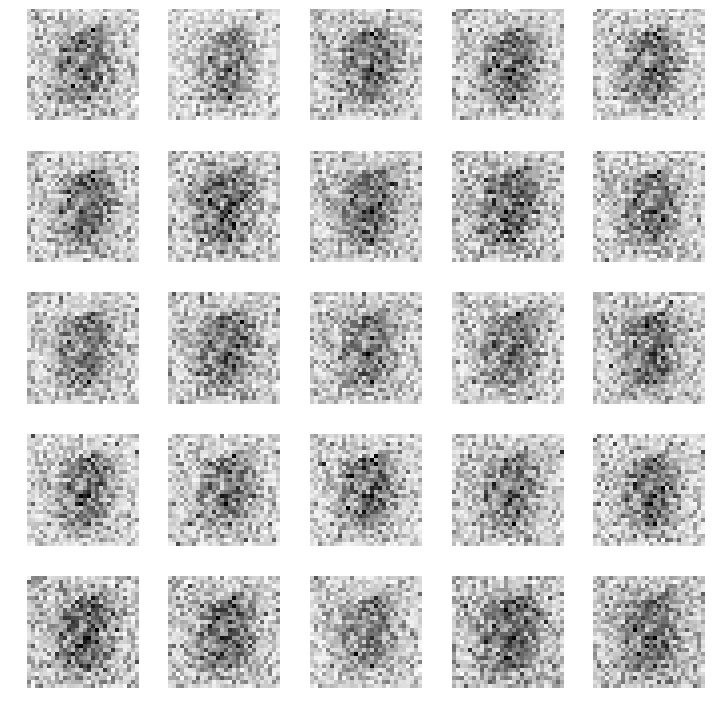

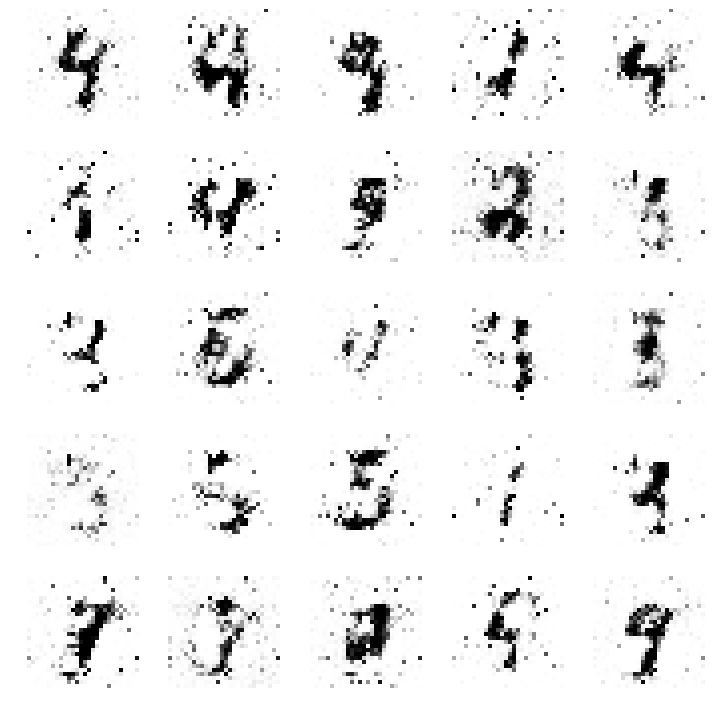

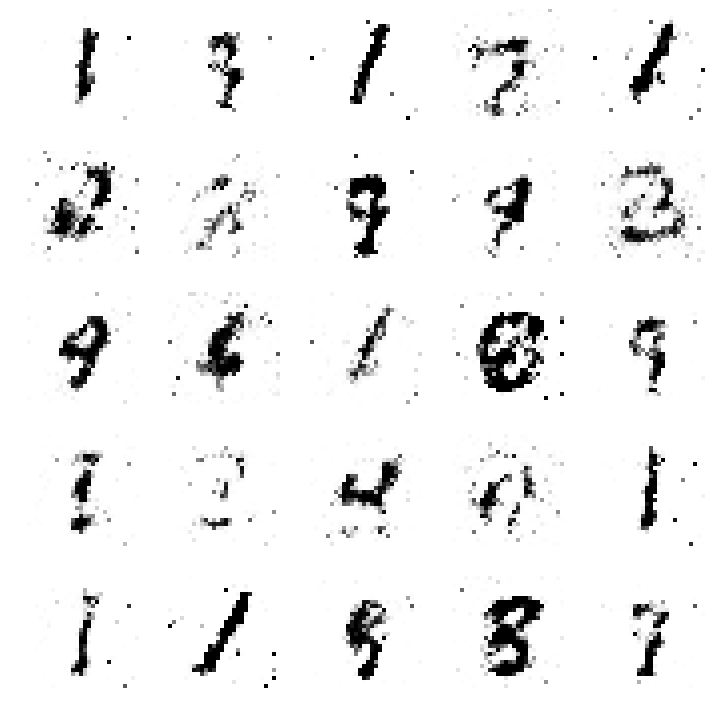

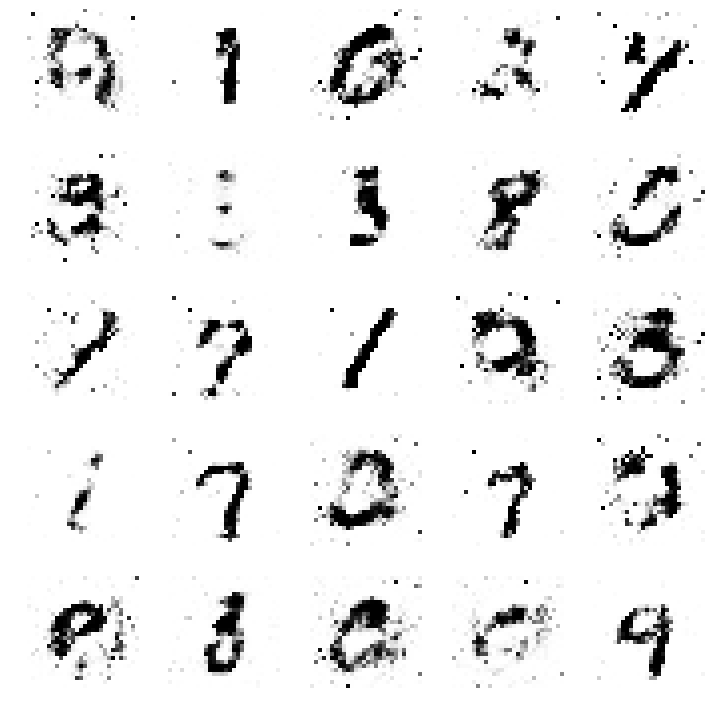

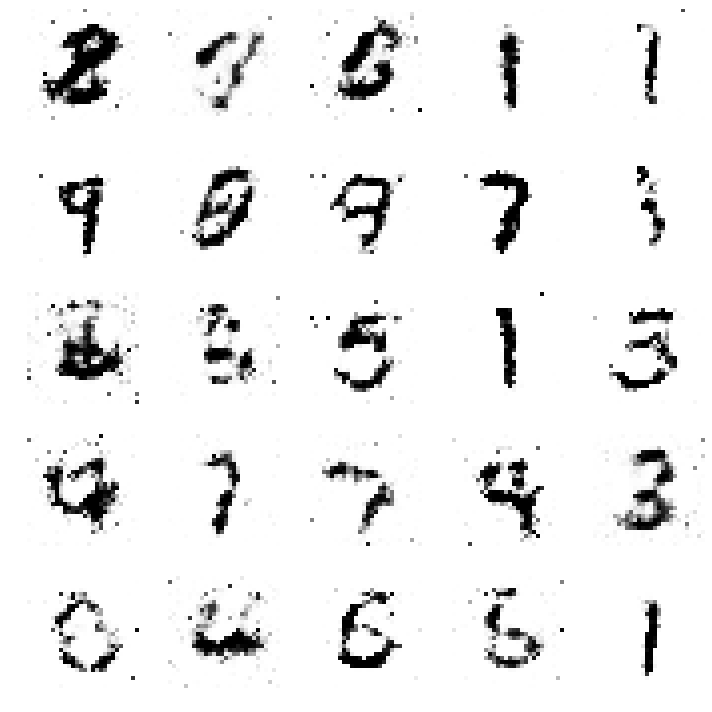

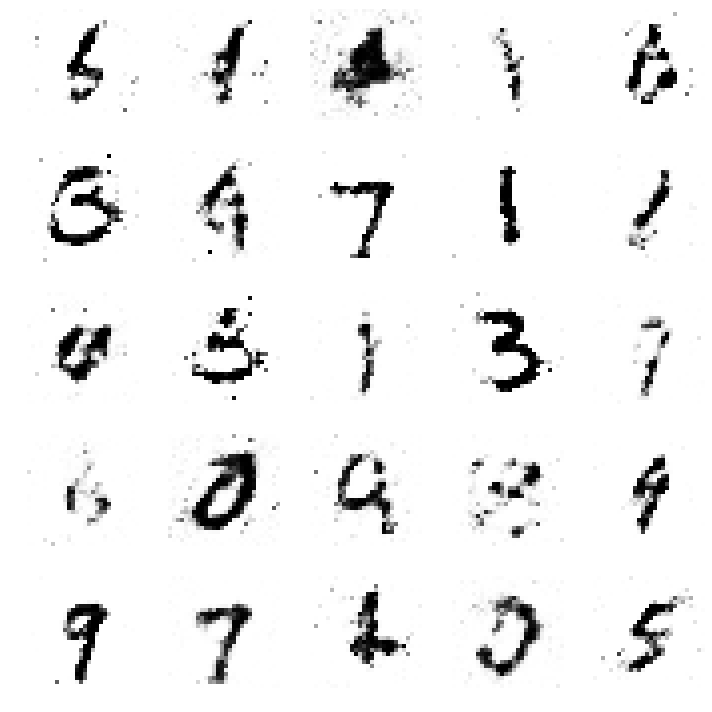

In [16]:
train_GAN(epochs=50, batch_size=128)